<a href="https://colab.research.google.com/github/kyotoman-koshida/bokete/blob/main/20220921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import japanize_matplotlib

import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### csvデータの読み込み

In [113]:
train_df = pd.read_csv('/content/drive/MyDrive/会社/nishika/bokete/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/会社/nishika/bokete/data/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/会社/nishika/bokete/data/sample_submission.csv')

### 画像データの読み込みと、パスのデータフレームへの埋め込み

In [114]:
# データのロード
INPUT = "/content/drive/MyDrive/会社/nishika/bokete/data" # 所望のディレクトリに変更してください。
train_image_path = "/train/"
test_image_path = "/test/"

# train_df["img_path"] = train_image_path + train_df["odai_photo_file_name"]
# test_df["img_path"] = test_image_path + test_df["odai_photo_file_name"]

# train, testデータのshapeの確認
print(f"train_data: {train_df.shape}")
display(train_df.head())

print(f"test_data: {test_df.shape}")
display(test_df.head())

train_data: (24962, 4)


,id,odai_photo_file_name,text,is_laugh
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0


test_data: (6000, 3)


,id,odai_photo_file_name,text
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...


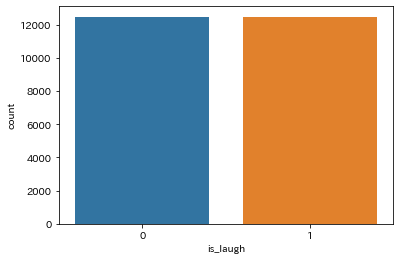

In [115]:
# 目的変数の分布を確認する
sns.countplot(x="is_laugh", data=train_df)

In [116]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

In [117]:
# 画像の重複があるか確認する
print(train_df["odai_photo_file_name"].duplicated().sum())
print(test_df["odai_photo_file_name"].duplicated().sum())

0
0


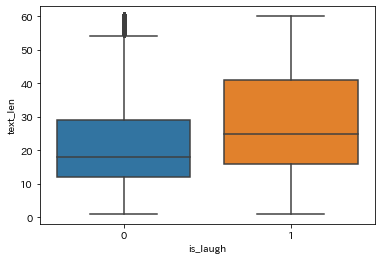

In [118]:
# 文書の長さとflagの関係を確認する
train_df["text_len"] = train_df["text"].str.len()
test_df["text_len"] = test_df["text"].str.len()

sns.boxplot(x="is_laugh", y="text_len", data=train_df)

画像のデータを特徴量として用いる

In [119]:
import numpy as np
import cv2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from tqdm import tqdm, tqdm_notebook
from keras.applications.densenet import preprocess_input, DenseNet121

In [120]:
class CFG:# 単に変数を格納するだけのクラス
    img_size = 224
    batch_size = 17

In [121]:
# 入力された画像変数を224x224の正方形に整形する関数
def resize_to_square(im):
    old_size = im.shape[:2] 
    ratio = float(CFG.img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # 画像サイズを224×224に変更します
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = CFG.img_size - new_size[1]
    delta_h = CFG.img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

# 画像データの読み込み用の関数
def load_image(ids, is_train=True):
  if is_train:
    image = cv2.imread(train_image_path+ids)# ここで画像を読み込んでいる・・・？
  else:
    image = cv2.imread(test_image_path+ids)
  new_image = resize_to_square(image)
  new_image = preprocess_input(new_image)
  return new_image

In [122]:
#謎の処理
inp = Input((224,224,3))
backbone = DenseNet121(input_tensor = inp, include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

In [123]:
image_df_train = train_df[["id", "odai_photo_file_name"]].copy()
image_df_train.head()

,id,odai_photo_file_name
0,ge5kssftl,9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg


In [124]:
image_ids = image_df_train["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1
#　n_batchesは何を意味している？

In [125]:
# 謎の処理
features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id)
        except:
          print("Error")
    batch_preds = m.predict(batch_images) #この段階で既に予測をしている？何を予測している？？
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

  0%|          | 0/1469 [00:00<?, ?it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  0%|          | 2/1469 [00:01<19:57,  1.22it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  0%|          | 4/1469 [00:02<08:45,  2.79it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  0%|          | 6/1469 [00:02<05:33,  4.39it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|          | 8/1469 [00:02<04:16,  5.69it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|          | 10/1469 [00:03<04:04,  5.96it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|          | 12/1469 [00:03<03:35,  6.75it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|          | 14/1469 [00:03<03:21,  7.22it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|          | 16/1469 [00:03<03:13,  7.53it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|          | 18/1469 [00:04<03:11,  7.56it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|▏         | 20/1469 [00:04<03:10,  7.62it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  1%|▏         | 22/1469 [00:04<03:04,  7.84it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  2%|▏         | 24/1469 [00:04<02:58,  8.11it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  2%|▏         | 26/1469 [00:05<03:09,  7.63it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  2%|▏         | 28/1469 [00:05<03:13,  7.44it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  2%|▏         | 30/1469 [00:05<03:04,  7.80it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  2%|▏         | 32/1469 [00:05<03:04,  7.78it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  2%|▏         | 34/1469 [00:06<03:17,  7.28it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  2%|▏         | 36/1469 [00:06<03:25,  6.98it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  3%|▎         | 38/1469 [00:06<03:06,  7.68it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  3%|▎         | 40/1469 [00:06<03:00,  7.91it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  3%|▎         | 42/1469 [00:07<03:01,  7.85it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  3%|▎         | 44/1469 [00:07<02:56,  8.07it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  3%|▎         | 46/1469 [00:07<03:03,  7.77it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  3%|▎         | 48/1469 [00:07<03:02,  7.80it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  3%|▎         | 50/1469 [00:08<03:01,  7.83it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▎         | 52/1469 [00:08<02:57,  7.99it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▎         | 54/1469 [00:08<03:01,  7.80it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▍         | 56/1469 [00:08<03:03,  7.72it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▍         | 58/1469 [00:09<03:04,  7.63it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▍         | 60/1469 [00:09<03:03,  7.70it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▍         | 62/1469 [00:09<03:00,  7.79it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▍         | 63/1469 [00:09<02:54,  8.04it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  4%|▍         | 65/1469 [00:10<03:40,  6.38it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▍         | 67/1469 [00:10<03:51,  6.07it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▍         | 69/1469 [00:10<04:04,  5.74it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▍         | 70/1469 [00:11<04:23,  5.31it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▍         | 72/1469 [00:11<04:24,  5.27it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▍         | 73/1469 [00:11<04:18,  5.40it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▌         | 75/1469 [00:12<04:34,  5.09it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▌         | 77/1469 [00:12<04:25,  5.25it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▌         | 78/1469 [00:12<04:25,  5.25it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  5%|▌         | 80/1469 [00:13<04:51,  4.77it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 82/1469 [00:13<05:10,  4.47it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 83/1469 [00:13<05:26,  4.25it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 84/1469 [00:14<06:01,  3.83it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 85/1469 [00:14<06:01,  3.83it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 86/1469 [00:14<05:57,  3.87it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 87/1469 [00:15<05:41,  4.05it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 88/1469 [00:15<06:11,  3.72it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 90/1469 [00:15<05:50,  3.94it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▌         | 91/1469 [00:16<05:56,  3.86it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▋         | 92/1469 [00:16<06:34,  3.49it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▋         | 94/1469 [00:16<05:47,  3.96it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  6%|▋         | 95/1469 [00:17<05:53,  3.88it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 96/1469 [00:17<06:01,  3.80it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 97/1469 [00:17<06:15,  3.65it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 98/1469 [00:18<06:07,  3.73it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 100/1469 [00:18<05:18,  4.30it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 102/1469 [00:18<05:01,  4.53it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 104/1469 [00:19<04:49,  4.72it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 105/1469 [00:19<04:46,  4.76it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 106/1469 [00:19<05:08,  4.42it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 107/1469 [00:20<05:30,  4.12it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 108/1469 [00:20<05:37,  4.03it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  7%|▋         | 110/1469 [00:20<05:27,  4.14it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 111/1469 [00:21<05:33,  4.07it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 112/1469 [00:21<05:46,  3.92it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 114/1469 [00:21<05:16,  4.29it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 115/1469 [00:22<05:28,  4.12it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 116/1469 [00:22<05:31,  4.09it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 118/1469 [00:22<05:41,  3.95it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 120/1469 [00:23<05:20,  4.21it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 121/1469 [00:23<05:38,  3.98it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 122/1469 [00:23<06:24,  3.50it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  8%|▊         | 124/1469 [00:24<06:03,  3.70it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▊         | 125/1469 [00:24<05:59,  3.74it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▊         | 126/1469 [00:25<06:05,  3.68it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▊         | 127/1469 [00:25<06:19,  3.54it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 129/1469 [00:25<05:31,  4.04it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 130/1469 [00:26<05:34,  4.00it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 131/1469 [00:26<05:49,  3.83it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 132/1469 [00:26<05:43,  3.90it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 134/1469 [00:26<05:06,  4.36it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 135/1469 [00:27<05:36,  3.96it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 136/1469 [00:27<05:32,  4.01it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 137/1469 [00:27<05:40,  3.91it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


  9%|▉         | 139/1469 [00:28<05:20,  4.15it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|▉         | 140/1469 [00:28<06:15,  3.54it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|▉         | 141/1469 [00:28<06:20,  3.49it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|▉         | 142/1469 [00:29<06:33,  3.37it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|▉         | 143/1469 [00:29<07:07,  3.10it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|▉         | 144/1469 [00:29<06:33,  3.37it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|▉         | 145/1469 [00:30<07:09,  3.08it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|▉         | 146/1469 [00:30<07:04,  3.12it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 147/1469 [00:30<07:23,  2.98it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 148/1469 [00:31<07:37,  2.88it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 149/1469 [00:31<07:44,  2.84it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 150/1469 [00:31<07:25,  2.96it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 151/1469 [00:32<07:50,  2.80it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 152/1469 [00:32<07:34,  2.90it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 153/1469 [00:33<08:04,  2.72it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 10%|█         | 154/1469 [00:33<07:58,  2.75it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 11%|█         | 155/1469 [00:33<07:01,  3.12it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 11%|█         | 156/1469 [00:33<06:32,  3.35it/s]

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


 11%|█         | 157/1469 [00:34<04:46,  4.57it/s]


Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


KeyboardInterrupt: ignored

In [ ]:
image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

In [ ]:
# trainのデータに結合します。
train_df = pd.merge(train_df, image_feature, on="odai_photo_file_name", how="left")

In [ ]:
train_df.shape

In [ ]:
# testデータでも同様なことを行って行きます
image_df_test = test_df[["id", "odai_photo_file_name"]].copy()

image_ids = image_df_test["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1


features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id, is_train=False)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

test_df = pd.merge(test_df, image_feature, on="odai_photo_file_name", how="left")

In [87]:
test_df.shape

(6000, 259)

# Create Text Features

続いてボケての文章について、BERTモデルを用いて特徴量化していきます。
特徴量化については、以下のディスカッションを参考にさせていただきます。  
[japanese-roberta-baseでテキストデータをembeddingする(小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~ より)](https://www.nishika.com/competitions/21/topics/163)


In [88]:
### 文字整形の関数群
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

In [89]:
# テキストをベクトル化するクラス
class BertSequenceVectorizer:
    def __init__(self, model_name: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.do_lower_case = True 
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 256


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

In [90]:
BSV = BertSequenceVectorizer('rinna/japanese-roberta-base')

## テキストの欠損値を補間します
train_df["text"] = train_df["text"].fillna('NaN')
test_df["text"] = test_df["text"].fillna('NaN')

## BERT特徴量 
features_text_train = np.stack(train_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)
features_text_test = np.stack(test_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

Some weights of the model checkpoint at rinna/japanese-roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [91]:
## テキスト特徴量
features_text_train_df = pd.DataFrame(features_text_train).add_prefix("Roberta-text")
features_text_test_df = pd.DataFrame(features_text_test).add_prefix("Roberta-text")

train_df = pd.concat([train_df, features_text_train_df], axis=1)
test_df = pd.concat([test_df, features_text_test_df], axis=1)

In [92]:
print(train_df.shape)
print(test_df.shape)

(24962, 1028)
(6000, 1027)


In [93]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

In [94]:
features_text_train_df.head()

,Roberta-text0,Roberta-text1,Roberta-text2,Roberta-text3,Roberta-text4,Roberta-text5,Roberta-text6,Roberta-text7,Roberta-text8,Roberta-text9,...,Roberta-text758,Roberta-text759,Roberta-text760,Roberta-text761,Roberta-text762,Roberta-text763,Roberta-text764,Roberta-text765,Roberta-text766,Roberta-text767
0,-0.107626,0.055327,0.332656,0.084826,0.196388,0.056368,0.166598,0.171358,-0.125276,-0.010135,...,0.051979,0.092719,0.048414,-0.046145,0.054659,0.179387,0.120467,-0.295126,0.274085,-0.037685
1,-0.142536,0.011938,-0.374652,-0.115362,-0.305899,-0.063437,0.198552,0.156238,0.271021,0.012268,...,0.147448,0.136201,-0.503051,0.291768,0.006177,0.292241,-0.337630,-0.133204,0.129636,-0.336098
2,0.021675,0.080549,0.094279,-0.017915,-0.029713,0.266389,0.034300,0.178127,-0.016939,0.055436,...,0.233712,0.031985,-0.288342,0.062656,0.103273,0.026101,-0.175331,-0.261590,0.118919,0.037961
3,0.119710,-0.049277,-0.053823,0.051799,0.046368,0.226661,0.464821,0.019133,0.023530,-0.021767,...,-0.030282,0.084566,0.104745,0.077361,-0.079214,-0.003724,-0.025880,-0.227838,0.297882,-0.018557
4,-0.170697,0.026444,-0.092976,-0.285846,0.031922,0.176804,0.039082,-0.128412,0.100534,-0.295259,...,0.153430,0.033884,-0.338327,0.309102,-0.263616,-0.081696,0.281731,-0.213077,-0.276301,-0.181529


### データを分割する

In [95]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

In [96]:
print(train_x.shape)
print(valid_x.shape)

(19969, 1024)
(4993, 1024)


### モデル

In [97]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	train's binary_logloss: 0.617901	valid's binary_logloss: 0.665748
[100]	train's binary_logloss: 0.58002	valid's binary_logloss: 0.662468
[150]	train's binary_logloss: 0.549475	valid's binary_logloss: 0.661906
[200]	train's binary_logloss: 0.524817	valid's binary_logloss: 0.661837
[250]	train's binary_logloss: 0.502252	valid's binary_logloss: 0.662156
Early stopping, best iteration is:
[229]	train's binary_logloss: 0.512094	valid's binary_logloss: 0.661616


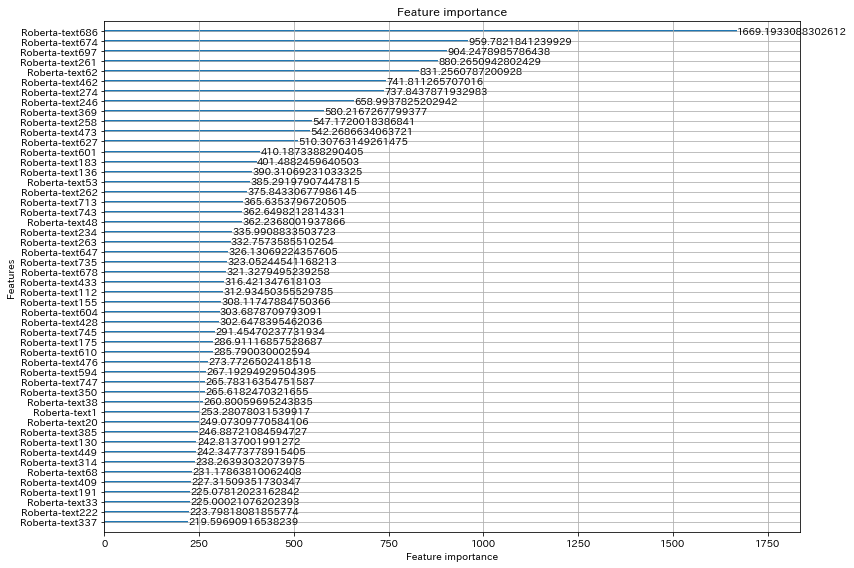

In [98]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [99]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.6030442619667534


Text(0.5, 52.0, 'Predict')

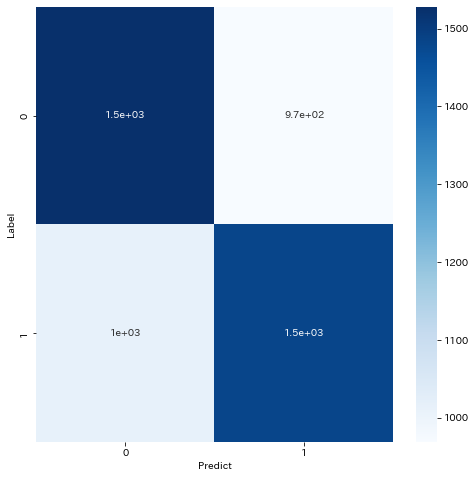

In [100]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

### 予測を行う

In [101]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [104]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.460060
1,tsgqmfpef,0.398389
2,owjcthkz2,0.439487
3,rvgaocjyy,0.486755
4,uxtwu5i69,0.591617


In [105]:
submission_df.to_csv('/content/drive/MyDrive/会社/nishika/bokete/data/submission.csv')